# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [1]:
import bson
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pyreadr
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn import tree, ensemble
import sys
import time
import importlib


In [255]:
from data_accessor import load_twibot, load_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df, load_other_bots, load_spammers, get_intraclass_labels, load_human_dataset_list, load_fake_followers, load_other_bots, get_shared_cols
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_dataset, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, plot_metrics, calculate_accuracy, analyze_twibot
from leaveonedatasetout import leave_dataset_out
from plotting import heatmap_train_on_one_test_on_another, process_tick_label
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from print_table import print_totoa_matrix, print_leave_one_out_table, print_single_dataset_score_table, get_max_score, print_intratype_test
from train_on_one_test_on_another import train_on_one_test_on_another, train_on_one_test_on_another_botometer_combined

importlib.reload(sys.modules['fit_and_score'])

<module 'fit_and_score' from '/home/jhays/bot-detection/fit_and_score.py'>

In [3]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    try:
        return namestr(df, globals())[0]
    except:
        return "Unknown"


## Load datasets and calculate scores

## Profile data

In [4]:
importlib.reload(sys.modules['data_accessor'])


<module 'data_accessor' from '/home/jhays/bot-detection/data_accessor.py'>

In [5]:
## BENCHMARK DATASETS
# twibot
twibot_df, twibot_2020_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_2020_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
twibot_scores = analyze_twibot(twibot_2020_one_hot, twibot_2020_one_hot_test, twibot_labels, twibot_labels_test)

# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

#rtbust
rtbust, cresci_rtbust_2019_one_hot, rtbust_labels = load_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_dataset(cresci_rtbust_2019_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_2017_one_hot, gilani_labels = load_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_dataset(gilani_2017_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(5)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci_2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_dataset(cresci_2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci_2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_dataset(cresci_2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee_2011, caverlee_2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee_2011_scores = analyze_dataset(caverlee_2011, caverlee_2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_2018_one_hot, cresci_stock_labels = load_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_dataset(cresci_stock_2018_one_hot, cresci_stock_labels, silent=True)

### SINGLE-CLASS DATAETS 
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_dataset(PROJ_PATH + "/data/pronbots-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_dataset(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
#verified
verified_df, verified_one_hot, verified_labels = load_dataset(PROJ_PATH + "/data/verified-2019_tweets.json", PROJ_PATH + "/data/verified-2019.tsv")


Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.2027328. Execution time: 0.10206317901611328 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.2956915. Execution time: 0.09286808967590332 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.3895593. Execution time: 0.09375309944152832 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.487244. Execution time: 0.09759211540222168 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.583878. Execution time: 0.09654974937438965 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.668466. Execution time: 0.08449292182922363 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.75255. Execution time: 0.08398771286010742 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 1665261923.8387096. Execution time: 0.0860605239868164 s
Starting kfold_cv at 10/08/22 16:45:23
Finished kfold_cv at 16

Starting kfold_cv at 10/08/22 16:45:32
Finished kfold_cv at 1665261935.5754178. Execution time: 3.406301498413086 s
Starting kfold_cv at 10/08/22 16:45:35
Finished kfold_cv at 1665261939.52156. Execution time: 3.945781946182251 s
Starting kfold_cv at 10/08/22 16:45:39
Finished kfold_cv at 1665261943.894449. Execution time: 4.372715950012207 s
Starting kfold_cv at 10/08/22 16:45:43
Finished kfold_cv at 1665261948.6662545. Execution time: 4.77161717414856 s
Starting kfold_cv at 10/08/22 16:45:48
Finished kfold_cv at 1665261953.7392862. Execution time: 5.072839021682739 s
Starting kfold_cv at 10/08/22 16:45:53
Finished kfold_cv at 1665261955.977989. Execution time: 2.2385079860687256 s
Starting kfold_cv at 10/08/22 16:45:55
Finished kfold_cv at 1665261958.4150305. Execution time: 2.4368526935577393 s
Starting kfold_cv at 10/08/22 16:45:58
Finished kfold_cv at 1665261960.9927127. Execution time: 2.577489137649536 s
Starting kfold_cv at 10/08/22 16:46:00
Finished kfold_cv at 1665261963.6848

In [7]:
midterm, midterm_2018_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_dataset(midterm_2018_one_hot, midterm_labels, kfold=True, silent=True)

Starting kfold_cv at 10/08/22 16:49:58
Finished kfold_cv at 1665262314.5642698. Execution time: 115.63479328155518 s
Starting kfold_cv at 10/08/22 16:51:54
Finished kfold_cv at 1665262454.4273741. Execution time: 139.8629264831543 s
Starting kfold_cv at 10/08/22 16:54:14
Finished kfold_cv at 1665262613.371202. Execution time: 158.94365048408508 s
Starting kfold_cv at 10/08/22 16:56:53
Finished kfold_cv at 1665262791.3181214. Execution time: 177.94651556015015 s
Starting kfold_cv at 10/08/22 16:59:51
Finished kfold_cv at 1665262990.2771246. Execution time: 198.958482503891 s
Starting kfold_cv at 10/08/22 17:03:10
Finished kfold_cv at 1665263043.8724139. Execution time: 53.594903230667114 s
Starting kfold_cv at 10/08/22 17:04:03
Finished kfold_cv at 1665263099.9042222. Execution time: 56.03143119812012 s
Starting kfold_cv at 10/08/22 17:04:59
Finished kfold_cv at 1665263157.3984616. Execution time: 57.493868350982666 s
Starting kfold_cv at 10/08/22 17:05:57
Finished kfold_cv at 166526321

In [8]:
yang, yang_2013_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_dataset(yang_2013_one_hot, yang_labels)

Starting kfold_cv at 10/08/22 17:07:56
Finished kfold_cv at 1665263296.643963. Execution time: 20.4278085231781 s
Starting kfold_cv at 10/08/22 17:08:16
Finished kfold_cv at 1665263320.2367184. Execution time: 23.592381715774536 s
Starting kfold_cv at 10/08/22 17:08:40
Finished kfold_cv at 1665263346.6104352. Execution time: 26.373342037200928 s
Starting kfold_cv at 10/08/22 17:09:06
Finished kfold_cv at 1665263376.6045103. Execution time: 29.99371886253357 s
Starting kfold_cv at 10/08/22 17:09:36
Finished kfold_cv at 1665263407.9593287. Execution time: 31.354448556900024 s
Starting kfold_cv at 10/08/22 17:10:07
Finished kfold_cv at 1665263416.669612. Execution time: 8.709883451461792 s
Starting kfold_cv at 10/08/22 17:10:16
Finished kfold_cv at 1665263425.417949. Execution time: 8.74814486503601 s
Starting kfold_cv at 10/08/22 17:10:25
Finished kfold_cv at 1665263434.1752443. Execution time: 8.756919860839844 s
Starting kfold_cv at 10/08/22 17:10:34
Finished kfold_cv at 1665263443.000

In [20]:
for c in yang.columns:
    print(c)

background_url
account creation time
favourites_count
followers_count
followings_count
geo_enabled
location
name
image_url
protected
statuses_count
timezone
verified


## Tweets data

In [ ]:
yang_tweets, yang_2013_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_dataset(yang_tweets, yang_2013_tweets_labels)


In [12]:
pan_2019_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_dataset(pan_2019_df, pan19_labels)


Starting kfold_cv at 10/08/22 17:15:22
Finished kfold_cv at 1665263727.4489458. Execution time: 4.9376091957092285 s
Starting kfold_cv at 10/08/22 17:15:27
Finished kfold_cv at 1665263734.3919053. Execution time: 6.942802906036377 s
Starting kfold_cv at 10/08/22 17:15:34
Finished kfold_cv at 1665263743.370601. Execution time: 8.978559255599976 s
Starting kfold_cv at 10/08/22 17:15:43
Finished kfold_cv at 1665263754.3293543. Execution time: 10.958407402038574 s
Starting kfold_cv at 10/08/22 17:15:54
Finished kfold_cv at 1665263767.1967025. Execution time: 12.867199659347534 s
Starting kfold_cv at 10/08/22 17:16:07
Finished kfold_cv at 1665263772.4642346. Execution time: 5.2671799659729 s
Starting kfold_cv at 10/08/22 17:16:12
Finished kfold_cv at 1665263779.871292. Execution time: 7.406908988952637 s
Starting kfold_cv at 10/08/22 17:16:19
Finished kfold_cv at 1665263789.293197. Execution time: 9.421753406524658 s
Starting kfold_cv at 10/08/22 17:16:29
Finished kfold_cv at 1665263800.680

In [ ]:
cresci_2017_tweets, cresci_2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci_2017_tweets_scores = analyze_dataset(cresci_2017_tweets, cresci_2017_tweets_labels, silent=True)


In [ ]:
cresci_2015_tweets, cresci_2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci_2015_tweets_scores = analyze_dataset(cresci_2015_tweets, cresci_2015_tweets_labels)


In [17]:
cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels = load_cresci_stock_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_2018_tweets_scores = analyze_dataset(cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels)


Starting kfold_cv at 10/08/22 21:00:56
Finished kfold_cv at 1665277474.0277402. Execution time: 217.7107925415039 s
Starting kfold_cv at 10/08/22 21:04:34
Finished kfold_cv at 1665277821.3640628. Execution time: 347.33601689338684 s
Starting kfold_cv at 10/08/22 21:10:21
Finished kfold_cv at 1665278289.3785093. Execution time: 468.0140676498413 s
Starting kfold_cv at 10/08/22 21:18:09
Finished kfold_cv at 1665278867.5976992. Execution time: 578.2188034057617 s
Starting kfold_cv at 10/08/22 21:27:47
Finished kfold_cv at 1665279545.5128956. Execution time: 677.9142198562622 s
Starting kfold_cv at 10/08/22 21:39:05
Finished kfold_cv at 1665279768.64007. Execution time: 223.12679862976074 s
Starting kfold_cv at 10/08/22 21:42:48
Finished kfold_cv at 1665280106.765172. Execution time: 338.1244237422943 s
Starting kfold_cv at 10/08/22 21:48:26
Finished kfold_cv at 1665280551.2374253. Execution time: 444.47169256210327 s
Starting kfold_cv at 10/08/22 21:55:51
Finished kfold_cv at 1665281097.4

In [94]:
cresci_stock_2018_tweets_scores

SyntaxError: invalid syntax (<ipython-input-94-6b3246885f36>, line 1)

In [28]:
datasets = [twibot_2020_one_hot, botometer_feedback_2019_one_hot, cresci_rtbust_2019_one_hot, gilani_2017_one_hot, cresci_2017_one_hot, cresci_2015_one_hot, cresci_stock_2018_one_hot, yang_2013_one_hot]
dataset_names = [process_tick_label(get_dataset_name(df)) for df in datasets]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]

scores = {
    'twibot-2020': twibot_scores, 
    'feedback-2019': botometer_feedback_scores, 
    'rtbust-2019': rtbust_scores, 
    'gilani-2017': gilani_derived_scores_avg, 
    'cresci-2017': cresci2017_scores, 
    'cresci-2015': cresci2015_scores, 
    'caverlee-2011': caverlee_2011_scores,
    'midterm-2018': midterm_scores, 
    'yang-2013': yang_scores,
    'stock-2018': cresci_stock_scores,
    'pan-2019': pan19_scores
}

rows = []

for name, scr in scores.items():
    row = {'name': name}
    for i, (a,p,r,f,ba) in enumerate(scr):
        row.update({
            f'a{i+1}': a,  #accuracy
            f'p{i+1}': p,  #precision
            f'r{i+1}': r,  #recall
            f'f{i+1}': f,  #f1
            f'ba{i+1}': ba #balanced accuracy
        })
    rows.append(row)
    
scores_df = pd.DataFrame(rows)
scores_df.to_csv("scores.csv", index=False)

twibot-2020
botometer-feedback-2019
cresci-rtbust-2019
gilani-2017
cresci-2017
cresci-2015
cresci-stock-2018
yang-2013


# Train on one, test on another

In [92]:
importlib.reload(sys.modules['data_accessor'])
importlib.reload(sys.modules['train_on_one_test_on_another'])
from train_on_one_test_on_another import train_on_one_test_on_another

In [93]:
balanced_rows = []
rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        print(get_dataset_name(train_on), get_dataset_name(test_on))
        rf = ensemble.RandomForestClassifier()
        balanced_rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, get_dataset_name(train_on), get_dataset_name(test_on), method=rf, balance=True))
        rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, get_dataset_name(train_on), get_dataset_name(test_on), method=rf, balance=False))
train_on_one_test_on_another_performance = pd.DataFrame(rows)
train_on_one_test_on_another_performance_balanced = pd.DataFrame(balanced_rows)


twibot_2020_one_hot twibot_2020_one_hot
twibot_2020_one_hot botometer_feedback_2019_one_hot
twibot_2020_one_hot cresci_rtbust_2019_one_hot
twibot_2020_one_hot gilani_2017_one_hot
twibot_2020_one_hot cresci_2017_one_hot
twibot_2020_one_hot cresci_2015_one_hot
twibot_2020_one_hot cresci_stock_2018_one_hot
twibot_2020_one_hot yang_2013_one_hot
botometer_feedback_2019_one_hot twibot_2020_one_hot
botometer_feedback_2019_one_hot botometer_feedback_2019_one_hot
botometer_feedback_2019_one_hot cresci_rtbust_2019_one_hot
botometer_feedback_2019_one_hot gilani_2017_one_hot
botometer_feedback_2019_one_hot cresci_2017_one_hot
botometer_feedback_2019_one_hot cresci_2015_one_hot
botometer_feedback_2019_one_hot cresci_stock_2018_one_hot
botometer_feedback_2019_one_hot yang_2013_one_hot
cresci_rtbust_2019_one_hot twibot_2020_one_hot
cresci_rtbust_2019_one_hot botometer_feedback_2019_one_hot
cresci_rtbust_2019_one_hot cresci_rtbust_2019_one_hot
cresci_rtbust_2019_one_hot gilani_2017_one_hot
cresci_rtbu

/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cresci_2015_one_hot gilani_2017_one_hot
cresci_2015_one_hot cresci_2017_one_hot
cresci_2015_one_hot cresci_2015_one_hot
cresci_2015_one_hot cresci_stock_2018_one_hot
cresci_2015_one_hot yang_2013_one_hot
cresci_stock_2018_one_hot twibot_2020_one_hot
cresci_stock_2018_one_hot botometer_feedback_2019_one_hot
cresci_stock_2018_one_hot cresci_rtbust_2019_one_hot
cresci_stock_2018_one_hot gilani_2017_one_hot
cresci_stock_2018_one_hot cresci_2017_one_hot
cresci_stock_2018_one_hot cresci_2015_one_hot
cresci_stock_2018_one_hot cresci_stock_2018_one_hot
cresci_stock_2018_one_hot yang_2013_one_hot


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


yang_2013_one_hot twibot_2020_one_hot
yang_2013_one_hot botometer_feedback_2019_one_hot
yang_2013_one_hot cresci_rtbust_2019_one_hot


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


yang_2013_one_hot gilani_2017_one_hot
yang_2013_one_hot cresci_2017_one_hot
yang_2013_one_hot cresci_2015_one_hot
yang_2013_one_hot cresci_stock_2018_one_hot


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


yang_2013_one_hot yang_2013_one_hot


In [99]:
importlib.reload(sys.modules['print_table'])
from print_table import print_totoa_matrix

In [100]:
print_totoa_matrix(train_on_one_test_on_another_performance, 'a')


\begin{tikzpicture}[]
  \matrix[matrix of nodes,row sep=-\pgflinewidth, column sep=-.1em,
nodes={{rectangle}},
column 1/.style={{anchor=east}},]{
\data{\small{feedback-2019}} & |[fill={rgb,255:red,0;green,0;blue,205}, value=1.0]|&|[fill={rgb,255:red,229;green,198;blue,173}, value=0.39]|&|[fill={rgb,255:red,245;green,234;blue,205}, value=0.46]|&|[fill={rgb,255:red,244;green,244;blue,223}, value=0.52]|&|[fill={rgb,255:red,249;green,243;blue,214}, value=0.48]|&|[fill={rgb,255:red,188;green,188;blue,219}, value=0.63]|&|[fill={rgb,255:red,249;green,243;blue,214}, value=0.48]|&|[fill={rgb,255:red,210;green,158;blue,138}, value=0.31]| \\
\data{\small{cresci-2015}} & |[fill={rgb,255:red,147;green,147;blue,216}, value=0.71]|&|[fill={rgb,255:red,0;green,0;blue,205}, value=1.0]|&|[fill={rgb,255:red,214;green,214;blue,220}, value=0.58]|&|[fill={rgb,255:red,252;green,250;blue,219}, value=0.49]|&|[fill={rgb,255:red,248;green,240;blue,210}, value=0.47]|&|[fill={rgb,255:red,224;green,224;blue,221}, va

In [101]:
print_totoa_matrix(train_on_one_test_on_another_performance, 'f')


\begin{tikzpicture}[]
  \matrix[matrix of nodes,row sep=-\pgflinewidth, column sep=-.1em,
nodes={{rectangle}},
column 1/.style={{anchor=east}},]{
\data{\small{feedback-2019}} & |[fill={rgb,255:red,0;green,0;blue,205}, value=1.0]|&|[fill={rgb,255:red,232;green,232;blue,222}, value=0.09]|&|[fill={rgb,255:red,140;green,140;blue,215}, value=0.45]|&|[fill={rgb,255:red,202;green,202;blue,220}, value=0.21]|&|[fill={rgb,255:red,215;green,215;blue,221}, value=0.16]|&|[fill={rgb,255:red,168;green,168;blue,217}, value=0.34]|&|[fill={rgb,255:red,197;green,197;blue,219}, value=0.23]|&|[fill={rgb,255:red,207;green,207;blue,220}, value=0.19]| \\
\data{\small{cresci-2015}} & |[fill={rgb,255:red,202;green,202;blue,220}, value=0.21]|&|[fill={rgb,255:red,0;green,0;blue,205}, value=1.0]|&|[fill={rgb,255:red,89;green,89;blue,211}, value=0.65]|&|[fill={rgb,255:red,255;green,255;blue,224}, value=0.0]|&|[fill={rgb,255:red,250;green,250;blue,223}, value=0.02]|&|[fill={rgb,255:red,255;green,255;blue,224}, value

In [102]:
print_totoa_matrix(train_on_one_test_on_another_performance_balanced, 'a')


\begin{tikzpicture}[]
  \matrix[matrix of nodes,row sep=-\pgflinewidth, column sep=-.1em,
nodes={{rectangle}},
column 1/.style={{anchor=east}},]{
\data{\small{feedback-2019}} & |[fill={rgb,255:red,49;green,49;blue,208}, value=0.9]|&|[fill={rgb,255:red,49;green,49;blue,208}, value=0.9]|&|[fill={rgb,255:red,158;green,158;blue,216}, value=0.69]|&|[fill={rgb,255:red,230;green,230;blue,222}, value=0.55]|&|[fill={rgb,255:red,250;green,250;blue,223}, value=0.51]|&|[fill={rgb,255:red,184;green,184;blue,218}, value=0.64]|&|[fill={rgb,255:red,234;green,234;blue,222}, value=0.54]|&|[fill={rgb,255:red,234;green,234;blue,222}, value=0.54]| \\
\data{\small{cresci-2015}} & |[fill={rgb,255:red,240;green,240;blue,222}, value=0.53]|&|[fill={rgb,255:red,0;green,0;blue,205}, value=1.0]|&|[fill={rgb,255:red,162;green,162;blue,217}, value=0.68]|&|[fill={rgb,255:red,254;green,254;blue,223}, value=0.5]|&|[fill={rgb,255:red,254;green,254;blue,223}, value=0.5]|&|[fill={rgb,255:red,254;green,254;blue,223}, value

In [75]:
importlib.reload(sys.modules['plotting'])
from plotting import heatmap_train_on_one_test_on_another

In [58]:
tootoa_a3 = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'accuracy', "rf")
tootoa_a3.to_csv(f"tootoa_a{depth}.csv")

KeyError: 'a3'

In [ ]:
depth=3
tootoa_f = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'f1', "rf")
tootoa_f.to_csv(f"tootoa_f{depth}.csv")

# Leave-one-dataset-out

In [111]:
rows = []

for i in range(len(datasets)):
    rf = ensemble.RandomForestClassifier()
    rows.append(leave_dataset_out(i, datasets, dataset_names, labels, method=rf))
    
leave_one_out_scores = pd.DataFrame(rows)

In [115]:
importlib.reload(sys.modules['print_table'])
importlib.reload(sys.modules['leaveonedatasetout'])
importlib.reload(sys.modules['plotting'])

<module 'plotting' from '/home/jhays/bot-detection/plotting.py'>

In [116]:
from print_table import print_leave_one_out_table
from leaveonedatasetout import leave_dataset_out


In [117]:
print_leave_one_out_table(leave_one_out_scores, random_forest=True)

twibot-2020 & 0.45/0.18/0.50 \\
feedback-2019 & 0.65/0.40/0.57 \\
rtbust-2019 & 0.54/0.36/0.55 \\
gilani-2017 & 0.56/0.11/0.50 \\
cresci-2017 & 0.77/0.83/0.76 \\
cresci-2015 & 0.91/0.94/0.89 \\
stock-2018 & 0.66/0.66/0.66 \\
yang-2013 & 0.32/0.21/0.67 \\


## Analysis of each of the specialized classifiers in Botometer

In [118]:
def get_columns(df):
    return df.columns[~df.columns.str.contains('location') & ~df.columns.str.contains('utc') & ~df.columns.str.contains('time_zone')& ~df.columns.str.contains('lang')]



### humans

In [130]:
human_df_list = load_human_dataset_list()
human_df, human_dataset_class_labels = get_intraclass_labels(human_df_list)


In [163]:
human_acc, _, _, human_f1 = train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=3, silent=False, prec_rec=False, balance=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:03:00
|--- followers_count <= 10696.00
|   |--- friends_count <= 0.50
|   |   |--- statuses_count <= 93.50
|   |   |   |--- weights: [146.00, 0.00, 1.00, 8.00, 2.00] class: 0
|   |   |--- statuses_count >  93.50
|   |   |   |--- weights: [227.00, 2.00, 1.00, 12.00, 1459.00] class: 4
|   |--- friends_count >  0.50
|   |   |--- statuses_count <= 10714.50
|   |   |   |--- weights: [14315.00, 190.00, 128.00, 94.00, 2201.00] class: 0
|   |   |--- statuses_count >  10714.50
|   |   |   |--- weights: [639.00, 66.00, 21.00, 329.00, 1172.00] class: 4
|--- followers_count >  10696.00
|   |--- followers_count <= 208160.50
|   |   |--- statuses_count <= 36848.00
|   |   |   |--- weights: [76.00, 23.00, 763.00, 220.00, 39.00] class: 2
|   |   |--- statuses_count >  36848.00
|   |   |   |--- weights: [6.00, 12.00, 65.00, 161.00, 50.00] class: 3
|   |--- followers_count >  208160.50
|   |   |--- statuses_count <= 12982.50
|   |   |   |--- weights: 

In [164]:
human_bacc, *_ = train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=3, silent=False, prec_rec=False, balance=True)


Starting train_test_fit_and_score_clf at 10/09/22 01:03:10
|--- followers_count <= 13262.00
|   |--- followers_count <= 753.50
|   |   |--- friends_count <= 0.50
|   |   |   |--- weights: [8.00, 0.00, 0.00, 2.00, 86.00] class: 4
|   |   |--- friends_count >  0.50
|   |   |   |--- weights: [267.00, 158.00, 1.00, 13.00, 170.00] class: 0
|   |--- followers_count >  753.50
|   |   |--- friends_count <= 2322.50
|   |   |   |--- weights: [21.00, 58.00, 11.00, 102.00, 46.00] class: 3
|   |   |--- friends_count >  2322.50
|   |   |   |--- weights: [5.00, 42.00, 0.00, 0.00, 5.00] class: 1
|--- followers_count >  13262.00
|   |--- followers_count <= 211424.50
|   |   |--- statuses_count <= 15204.50
|   |   |   |--- weights: [3.00, 13.00, 45.00, 24.00, 1.00] class: 2
|   |   |--- statuses_count >  15204.50
|   |   |   |--- weights: [0.00, 14.00, 10.00, 74.00, 4.00] class: 3
|   |--- followers_count >  211424.50
|   |   |--- statuses_count <= 13698.00
|   |   |   |--- weights: [0.00, 3.00, 147.00,

### simple bots

In [133]:

simple_df = caverlee_2011[caverlee_2011_labels.values == 1].rename(columns={'CreatedAt': 'created_at', 'NumerOfFollowings': 'friends_count', 'NumberOfFollowers': 'followers_count', "NumberOfTweets": 'statuses_count'})
simple_df


,created_at,friends_count,followers_count,statuses_count,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,1.158556e+09,3269,3071,861,8,132
1,1.161974e+09,1949,793,226,9,134
2,1.162133e+09,1119,9644,38674,12,158
3,1.168796e+09,2174,6029,12718,11,121
4,1.169954e+09,7731,7029,873,6,70
...,...,...,...,...,...,...
22218,1.280721e+09,63,10,29,12,0
22219,1.280722e+09,83,10,35,8,0
22220,1.280723e+09,67,9,21,13,0
22221,1.280724e+09,35,4,17,12,0


In [135]:
simple_df.columns

Index(['created_at', 'friends_count', 'followers_count', 'statuses_count',
       'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'],
      dtype='object')

### spammers

In [176]:
spammers_intradataset, spammers_labels, spammers_n_datasets = load_spammers(intradataset=True)
spammers_acc, _, _, spammers_f1 = train_test_fit_and_score(spammers_intradataset, spammers_labels, depth=4, silent=False, prec_rec=False, balance=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:13:46
|--- favourites_count <= 13.50
|   |--- followers_count <= 15.50
|   |   |--- friends_count <= 23.50
|   |   |   |--- time_zone_Athens <= 0.50
|   |   |   |   |--- weights: [1.00, 8.00, 4.00, 0.00, 0.00, 68.00, 0.00, 30.00] class: 5
|   |   |   |--- time_zone_Athens >  0.50
|   |   |   |   |--- weights: [318.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- friends_count >  23.50
|   |   |   |--- statuses_count <= 97.50
|   |   |   |   |--- weights: [0.00, 2706.00, 2.00, 4.00, 0.00, 1.00, 0.00, 1.00] class: 1
|   |   |   |--- statuses_count >  97.50
|   |   |   |   |--- weights: [4.00, 3.00, 1.00, 0.00, 0.00, 7.00, 0.00, 1.00] class: 5
|   |--- followers_count >  15.50
|   |   |--- lang_en <= 0.50
|   |   |   |--- lang_it <= 0.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 791.00, 56.00, 0.00, 0.00, 10.00] class: 3
|   |   |   |--- lang_it >  0.50
|   |   |   |   |--- weights: [397.00, 0.00, 0.00, 0.00, 0

In [246]:
spammers_df, spammers_labels = load_spammers(intradataset=True, balance=True)
spammers_bacc, *_ = train_test_fit_and_score(spammers_intradataset, spammers_labels, depth=4, silent=False, prec_rec=False, balance=True)


Starting train_test_fit_and_score_clf at 10/09/22 01:48:30
|--- time_zone_Hawaii <= 0.50
|   |--- favourites_count <= 34.00
|   |   |--- lang_it <= 0.50
|   |   |   |--- friends_count <= 166.50
|   |   |   |   |--- weights: [1.00, 79.00, 0.00, 1.00, 0.00, 66.00, 0.00, 1.00] class: 1
|   |   |   |--- friends_count >  166.50
|   |   |   |   |--- weights: [8.00, 0.00, 78.00, 81.00, 0.00, 9.00, 78.00, 0.00] class: 3
|   |   |--- lang_it >  0.50
|   |   |   |--- weights: [77.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |--- favourites_count >  34.00
|   |   |--- listed_count <= 3.50
|   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 81.00] class: 7
|   |   |--- listed_count >  3.50
|   |   |   |--- lang_en-gb <= 0.50
|   |   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 2.00, 0.00, 0.00] class: 5
|   |   |   |--- lang_en-gb >  0.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 2
|--- time_zone_Hawaii >  0.50
|   

### fake followers

In [215]:
importlib.reload(sys.modules['data_accessor'])

importlib.reload(sys.modules['fit_and_score'])



<module 'fit_and_score' from '/home/jhays/bot-detection/fit_and_score.py'>

In [216]:
from data_accessor import load_other_bots

In [188]:
fake_followers_df, fake_followers_labels, ff_n_datasets = load_fake_followers(intradataset=True)
ff_acc, _, _, ff_f1 = train_test_fit_and_score(fake_followers_df.drop(['created_at'], axis=1), fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:17:23
|--- profile_use_background_image_True <= 0.50
|   |--- weights: [97.00, 2690.00] class: 1
|--- profile_use_background_image_True >  0.50
|   |--- weights: [763.00, 0.00] class: 0

Accuracy: 0.9718468468468469
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665292643.8432705. Execution time: 0.07351279258728027 s


In [198]:
fake_followers_df, fake_followers_labels, ff_n_datasets = load_fake_followers(intradataset=True, balance=True)

ff_bacc, *_ = train_test_fit_and_score(fake_followers_df, fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:19:15
|--- favourites_count <= 3.50
|   |--- weights: [50.00, 828.00] class: 1
|--- favourites_count >  3.50
|   |--- weights: [819.00, 42.00] class: 0

Accuracy: 0.9517241379310345
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665292755.2653124. Execution time: 0.02261972427368164 s


### self-declared

In [143]:
botwiki_df, self_declared_df, botwiki_labels = load_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")


### political bots

In [144]:
political_bots, political_bots_df, political_bots_labels = load_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")


### other bots

In [217]:
other_bots, other_bots_labels, other_n_datasets = load_other_bots(intradataset=True)
other_acc, _, _, other_f1 = train_test_fit_and_score(other_bots, other_bots_labels, depth=3, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:31:12
|--- followers_count <= 768.00
|   |--- lang_it <= 0.50
|   |   |--- created_at <= 1504594688.00
|   |   |   |--- weights: [42.00, 29.00, 9.00, 5480.00] class: 3
|   |   |--- created_at >  1504594688.00
|   |   |   |--- weights: [7.00, 5.00, 21.00, 0.00] class: 2
|   |--- lang_it >  0.50
|   |   |--- created_at <= 1382974976.00
|   |   |   |--- weights: [2.00, 0.00, 46.00, 37.00] class: 2
|   |   |--- created_at >  1382974976.00
|   |   |   |--- weights: [0.00, 0.00, 174.00, 6.00] class: 2
|--- followers_count >  768.00
|   |--- followers_count <= 28345.00
|   |   |--- favourites_count <= 938.00
|   |   |   |--- weights: [18.00, 163.00, 2.00, 13.00] class: 1
|   |   |--- favourites_count >  938.00
|   |   |   |--- weights: [27.00, 120.00, 27.00, 130.00] class: 3
|   |--- followers_count >  28345.00
|   |   |--- created_at <= 1459631552.00
|   |   |   |--- weights: [13.00, 568.00, 1.00, 2.00] class: 1
|   |   |--- created_at >  

In [218]:
other_bots, other_bots_labels, other_n_datasets = load_other_bots(intradataset=True, balance=True)
other_bacc, *_ = train_test_fit_and_score(other_bots, other_bots_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/09/22 01:32:01
|--- lang_it <= 0.50
|   |--- followers_count <= 510.50
|   |   |--- statuses_count <= 147.50
|   |   |   |--- friends_count <= 3.50
|   |   |   |   |--- weights: [0.00, 0.00, 0.00, 1.00] class: 3
|   |   |   |--- friends_count >  3.50
|   |   |   |   |--- weights: [21.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- statuses_count >  147.50
|   |   |   |--- created_at <= 1504549888.00
|   |   |   |   |--- weights: [15.00, 1.00, 1.00, 104.00] class: 3
|   |   |   |--- created_at >  1504549888.00
|   |   |   |   |--- weights: [0.00, 1.00, 7.00, 0.00] class: 2
|   |--- followers_count >  510.50
|   |   |--- created_at <= 1448836800.00
|   |   |   |--- lang_en <= 0.50
|   |   |   |   |--- weights: [2.00, 62.00, 1.00, 0.00] class: 1
|   |   |   |--- lang_en >  0.50
|   |   |   |   |--- weights: [32.00, 42.00, 1.00, 5.00] class: 1
|   |   |--- created_at >  1448836800.00
|   |   |   |--- statuses_count <= 49.00
|   |   |   |   |--- weigh

In [240]:
importlib.reload(sys.modules['print_table'])

<module 'print_table' from '/home/jhays/bot-detection/print_table.py'>

In [241]:
from print_table import print_intratype_test

In [242]:
intraclass_dict = {
    'humans': {
        'a': human_acc,
        'f': human_f1,
        'ba': human_bacc,
        'n_datasets': len(human_df_list)
    },
    'spammers': {
        'a': spammers_acc,
        'f': spammers_f1,
        'ba': spammers_bacc,
        'n_datasets': spammers_n_datasets
    },
    'fake followers': {
        'a': ff_acc,
        'f': ff_f1,
        'ba': ff_bacc,
        'n_datasets': ff_n_datasets
    },
    'other bots': {
        'a': other_acc,
        'f': other_f1,
        'ba': other_bacc  ,
        'n_datasets': other_n_datasets      
    }
}

In [243]:
print_intratype_test(intraclass_dict)

\data{humans} & 0.82/0.56 & 5 \\
\data{spammers} & 0.97/0.57 & 7 \\
\data{fake followers} & 0.97/0.95 & 2 \\
\data{other bots} & 0.95/0.82 & 4 \\


# Botometer combined datasets: train on one, test on same one

In [277]:
importlib.reload(sys.modules['fit_and_score'])
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_dataset, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy

importlib.reload(sys.modules['train_on_one_test_on_another'])
from train_on_one_test_on_another import train_on_one_test_on_another_botometer_combined

In [320]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
botometer_dataset_names = [get_dataset_name(df) for df in botometer_datasets]

In [283]:
rows = []
balanced_rows = []
for j, dataset in enumerate(botometer_datasets[0:]):
    print(get_dataset_name(dataset))
    rows.append(train_test_botometer_combined(dataset, human_df, get_dataset_name(dataset), max_depth=4, silent=False))
botometer_leave_one_out_scores = pd.DataFrame(rows)

simple_df
Starting train_test_fit_and_score_clf at 10/09/22 02:28:26
|--- friends_count <= 245.50
|   |--- weights: [11240.00, 3411.00] class: 0
|--- friends_count >  245.50
|   |--- weights: [6595.00, 14310.00] class: 1

Accuracy: 0.7178852643419572
Precision 0.6907039020657996
Recall: 0.8020879609062639
F1: 0.7422404933196299
Finished train_test_fit_and_score_clf at 1665296906.6579525. Execution time: 0.14499235153198242 s
Starting train_test_fit_and_score_clf at 10/09/22 02:28:26
|--- friends_count <= 301.50
|   |--- statuses_count <= 78.50
|   |   |--- weights: [1434.00, 2783.00] class: 1
|   |--- statuses_count >  78.50
|   |   |--- weights: [10521.00, 1349.00] class: 0
|--- friends_count >  301.50
|   |--- statuses_count <= 3112.00
|   |   |--- weights: [1512.00, 12387.00] class: 1
|   |--- statuses_count >  3112.00
|   |   |--- weights: [4266.00, 1304.00] class: 0

Accuracy: 0.8415073115860517
Precision 0.8307896483078965
Recall: 0.8536363636363636
F1: 0.8420580652393229
Finishe

|--- friends_count <= 12.50
|   |--- statuses_count <= 307.50
|   |   |--- weights: [36.00, 19.00] class: 0
|   |--- statuses_count >  307.50
|   |   |--- weights: [29.00, 452.00] class: 1
|--- friends_count >  12.50
|   |--- friends_count <= 50.50
|   |   |--- weights: [81.00, 48.00] class: 0
|   |--- friends_count >  50.50
|   |   |--- weights: [403.00, 48.00] class: 0

Accuracy: 0.8821428571428571
Precision 0.9298245614035088
Recall: 0.8091603053435115
F1: 0.8653061224489796
Finished train_test_fit_and_score_clf at 1665296907.4464343. Execution time: 0.020190715789794922 s
Starting train_test_fit_and_score_clf at 10/09/22 02:28:27
|--- friends_count <= 12.50
|   |--- statuses_count <= 307.50
|   |   |--- followers_count <= 3.50
|   |   |   |--- weights: [30.00, 1.00] class: 0
|   |   |--- followers_count >  3.50
|   |   |   |--- weights: [15.00, 16.00] class: 1
|   |--- statuses_count >  307.50
|   |   |--- followers_count <= 0.50
|   |   |   |--- weights: [4.00, 1.00] class: 0
|   

# Botometer combined datasets: train on one, test on another

In [299]:
importlib.reload(sys.modules['train_on_one_test_on_another'])

<module 'train_on_one_test_on_another' from '/home/jhays/bot-detection/train_on_one_test_on_another.py'>

In [300]:
from train_on_one_test_on_another import train_on_one_test_on_another_botometer_combined

In [306]:
rows = []
balanced_rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
        rf = ensemble.RandomForestClassifier()
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, 
                                                                    bots2, 
                                                                    human_df, 
                                                                    get_dataset_name(bots1), 
                                                                    get_dataset_name(bots2), 
                                                                    method=rf, 
                                                                    silent=True,
                                                                    balance=False
                                                                   ))
        balanced_rows.append(train_on_one_test_on_another_botometer_combined(bots1, 
                                                                    bots2, 
                                                                    human_df, 
                                                                    get_dataset_name(bots1), 
                                                                    get_dataset_name(bots2), 
                                                                    method=rf, 
                                                                    silent=True,
                                                                    balance=True
                                                                   ))
        
botometer_tootoa = pd.DataFrame(rows)   
botometer_tootoa_balanced = pd.DataFrame(rows)   

In [317]:
importlib.reload(sys.modules['print_table'])
from print_table import print_totoa_matrix

In [318]:
print_totoa_matrix(botometer_tootoa, 'f', start_x=-0.15, start_y=-1.75)


\begin{tikzpicture}[]
  \matrix[matrix of nodes,row sep=-\pgflinewidth, column sep=-.1em,
nodes={{rectangle}},
column 1/.style={{anchor=east}},]{
\data{\small{fake-followers}} & |[fill={rgb,255:red,5;green,5;blue,205}, value=0.98]|&|[fill={rgb,255:red,176;green,176;blue,218}, value=0.31]|&|[fill={rgb,255:red,117;green,117;blue,213}, value=0.54]|&|[fill={rgb,255:red,245;green,245;blue,223}, value=0.04]|&|[fill={rgb,255:red,57;green,57;blue,209}, value=0.77]|&|[fill={rgb,255:red,153;green,153;blue,216}, value=0.4]| \\
\data{\small{other-bots}} & |[fill={rgb,255:red,46;green,46;blue,208}, value=0.82]|&|[fill={rgb,255:red,28;green,28;blue,207}, value=0.89]|&|[fill={rgb,255:red,250;green,250;blue,223}, value=0.02]|&|[fill={rgb,255:red,63;green,63;blue,209}, value=0.75]|&|[fill={rgb,255:red,94;green,94;blue,212}, value=0.63]|&|[fill={rgb,255:red,127;green,127;blue,214}, value=0.5]| \\
\data{\small{political-bots}} & |[fill={rgb,255:red,215;green,215;blue,221}, value=0.16]|&|[fill={rgb,255:re

In [319]:
print_totoa_matrix(botometer_tootoa_balanced, 'a', start_x=-0.15, start_y=-1.75)

\begin{tikzpicture}[]
  \matrix[matrix of nodes,row sep=-\pgflinewidth, column sep=-.1em,
nodes={{rectangle}},
column 1/.style={{anchor=east}},]{
\data{\small{fake-followers}} & |[fill={rgb,255:red,9;green,9;blue,205}, value=0.98]|&|[fill={rgb,255:red,220;green,220;blue,221}, value=0.57]|&|[fill={rgb,255:red,174;green,174;blue,217}, value=0.66]|&|[fill={rgb,255:red,249;green,243;blue,214}, value=0.48]|&|[fill={rgb,255:red,102;green,102;blue,212}, value=0.8]|&|[fill={rgb,255:red,204;green,204;blue,220}, value=0.6]| \\
\data{\small{other-bots}} & |[fill={rgb,255:red,96;green,96;blue,212}, value=0.81]|&|[fill={rgb,255:red,65;green,65;blue,209}, value=0.87]|&|[fill={rgb,255:red,222;green,184;blue,161}, value=0.36]|&|[fill={rgb,255:red,121;green,121;blue,214}, value=0.76]|&|[fill={rgb,255:red,168;green,168;blue,217}, value=0.67]|&|[fill={rgb,255:red,208;green,208;blue,220}, value=0.59]| \\
\data{\small{political-bots}} & |[fill={rgb,255:red,250;green,250;blue,223}, value=0.51]|&|[fill={rgb,

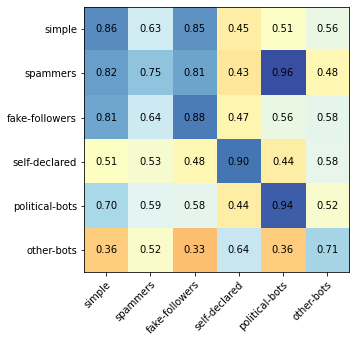

In [288]:
depth = 3
botometer_tootoa_a = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'accuracy', depth)
botometer_tootoa_a.to_csv(f"botometer_tootoa_a{depth}.csv")

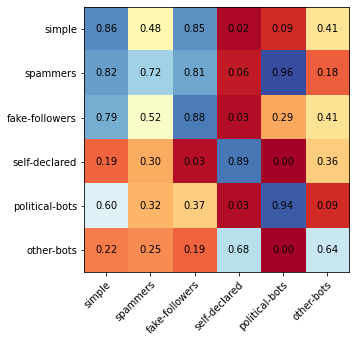

In [289]:
depth = 3
botometer_tootoa_f = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'f1', depth)
botometer_tootoa_f.to_csv(f"botometer_tootoa_f{depth}.csv")

# Botometer combined datasets: leave-one-dataset-out

In [321]:
importlib.reload(sys.modules['leaveonedatasetout'])

<module 'leaveonedatasetout' from '/home/jhays/bot-detection/leaveonedatasetout.py'>

In [323]:
from leaveonedatasetout import leave_dataset_out_botometer

In [326]:
rows = []
rf = ensemble.RandomForestClassifier()

for i in range(len(botometer_datasets)):
    rows.append(leave_dataset_out_botometer(i, botometer_datasets, botometer_dataset_names, human_df, method=rf))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

In [327]:
print_leave_one_out_table(botometer_leave_one_out_scores, random_forest=True)

simple & 0.36/0.53/0.69 \\
spammers & 0.49/0.66/0.51 \\
fake-followers & 0.80/0.89/0.81 \\
self-declared & 0.05/0.10/0.07 \\
political-bots & 0.97/0.98/1.00 \\
other-bots & 0.18/0.31/0.21 \\


# Ensemble of specialized decision trees

In [ ]:
def split_human_df(human_df, n_datasets, dataset_size):
    human_df_sample = human_df.sample(n=n_datasets*dataset_size)
    return [human_df_sample[i*dataset_size:(i+1)*dataset_size] for i in range(n_datasets)]

In [ ]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
human_dfs = split_human_df(human_df, len(botometer_datasets), dataset_size)

bot_names = [get_dataset_name(d) for d in botometer_datasets]


In [ ]:
importlib.reload(sys.modules['ensemble'])

from ensemble import get_ensemble_of_classifiers

In [ ]:
clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(botometer_datasets, human_dfs, bot_names, depth=4)


In [ ]:
score_ensemble_speicalized_trees(clfs, test_aggregate_df, test_labels_aggregate_concat)

## Ensembles of specialized random forests

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(botometer_datasets, human_dfs, bot_names, method=rf)

predictions = [rf_clfs[i].predict(test_aggregate_df) for i in range(n_classifiers)]
probs = [rf_clfs[i].predict_proba(test_aggregate_df) for i in range(n_classifiers)]
probs = [p[:,0] for p in probs]
most_confident_clf = [get_max_confidence_rf(probs, i)[0] for i in range(len(test_aggregate_df))]
max_prediction = [predictions[j][i] for i,j in enumerate(most_confident_clf)]
print(f"Accuracy: {accuracy_score(max_prediction, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(max_prediction, test_labels_aggregate_concat)}")

## Just simple decision rule

In [ ]:
all_clf = clfs[-1]
all_predictions = all_clf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions, test_labels_aggregate_concat)}")

## Just random forest

In [ ]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions_rf, test_labels_aggregate_concat)}")

## Testing on held-out set

In [ ]:
hold_out_test_df = pd.concat([cresci_stock_2018_one_hot[cols], cresci_rtbust_2019_one_hot[cols], gilani_2017_one_hot[cols]])
hold_out_test_labels = pd.concat([cresci_stock_labels, rtbust_labels, gilani_labels])

score_ensemble_speicalized_trees(clfs, hold_out_test_df, hold_out_test_labels)


In [ ]:
score_ensemble_speicalized_trees(clfs, cresci_stock_2018_one_hot[cols], cresci_stock_labels)

In [ ]:
score_ensemble_speicalized_trees(clfs, cresci_rtbust_2019_one_hot[cols], rtbust_labels)

In [ ]:
score_ensemble_speicalized_trees(clfs, gilani_2017_one_hot[cols], gilani_labels)

In [ ]:
all_predictions = all_clf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions, hold_out_test_labels)}")

In [ ]:
all_predictions = all_clf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions, cresci_stock_labels)}")

In [ ]:
all_predictions = all_clf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions, rtbust_labels)}")

In [ ]:
all_predictions = all_clf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, gilani_labels)}")
print(f"F1: {f1_score(all_predictions, gilani_labels)}")

In [ ]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions_rf, hold_out_test_labels)}")

In [ ]:
all_predictions_rf = all_clf_rf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions_rf, cresci_stock_labels)}")

In [ ]:
all_predictions_rf = all_clf_rf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions_rf, rtbust_labels)}")

In [ ]:
all_predictions_rf = all_clf_rf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, gilani_labels)}")
print(f"F1: {f1_score(all_predictions_rf, gilani_labels)}")